# Texts classification

__In this notebook__ you will build an algorithm that classifies SMS messages into ham or spam.
Like in many real-world cases, you only have a small dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from nltk.stem import WordNetLemmatizer
import re
%matplotlib inline

In [2]:
data = pd.read_csv("spam.csv", encoding = 'ISO-8859-1')
data = data[['v1', 'v2']]
data['v1'] = (data['v1'] == 'spam').astype(int)

texts = data['v2'].values
labels = data['v1'].values
data.head(10)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [3]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, labels, test_size=0.5, random_state=42)

In [4]:
# another dataset for sentiment analysis of movie reviews

# train_data = pd.read_csv("imdb_reviews/train.csv")
# test_data = pd.read_csv("imdb_reviews/test.csv")
# texts_train = train_data['reviews'].values
# y_train = train_data['sentiment'].values
# texts_test = test_data['reviews'].values
# y_test = test_data['sentiment'].values

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

In [5]:
import nltk
nltk.download('wordnet')
def preprocess(text):
    return re.findall(re.compile(r'[\w]+'), text.lower())


lemmatizer = WordNetLemmatizer()


def make_lemmas(tokens):
    return ' '.join(list(map(lambda t: lemmatizer.lemmatize(t), tokens)))




[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
# task: preprocess each comment in train and test
texts_train = [make_lemmas(preprocess(text=text)) for text in texts_train]
texts_test = [make_lemmas(preprocess(text=text)) for text in texts_test]

### Solving it: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. Please don't do that in the current assignment, though.
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [8]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
def make_bag_of_words(comments, number_of_features):
    bag = dict()
    for comment in comments:
        for word in comment.split(' '):
            if word not in bag.keys():
                bag[word] = 1
            else:
                bag[word] += 1

    return dict(sorted(bag.items(), key=lambda item: item[1], reverse=True)[:number_of_features])


k = 10000
bow_vocabulary = make_bag_of_words(comments=texts_train, number_of_features=k)

print('example features:', bow_vocabulary)

example features: {'i': 1500, 'to': 1125, 'you': 1094, 'a': 803, 'the': 640, 'u': 634, 'in': 461, 'is': 451, 'and': 449, 'it': 428, 'me': 426, 'for': 376, 'your': 367, 'my': 349, 'of': 300, 'call': 289, 'have': 284, 's': 281, 'that': 279, '2': 271, 'now': 253, 'on': 253, 'are': 252, 'so': 232, 't': 230, 'm': 225, 'but': 219, 'at': 216, 'or': 212, 'get': 211, 'we': 210, 'not': 207, 'can': 205, 'will': 203, 'ur': 196, 'do': 192, 'just': 186, 'if': 184, 'be': 179, 'no': 176, 'with': 175, 'lt': 167, 'this': 167, 'gt': 164, '4': 160, 'å': 158, 'what': 155, 'go': 155, 'how': 149, 'all': 148, 'when': 145, 'ok': 142, 'up': 139, 'free': 139, 'from': 136, 'day': 130, 'know': 130, 'then': 130, 'out': 126, 'time': 126, 'like': 121, 'll': 120, 'come': 120, 'got': 118, 'there': 114, 'am': 112, 'only': 111, 'love': 109, 'he': 107, 'good': 106, 'send': 102, 'want': 102, 'wa': 100, 'text': 98, 'one': 98, 'going': 91, 'txt': 91, 'r': 91, 'today': 91, 'da': 90, 'need': 87, 'home': 86, 'mobile': 84, 'lor'

In [9]:
def text_to_bow(text):
    bow_vector = [0] * len(bow_vocabulary)
    bow_list = list(bow_vocabulary.keys())

    for token in text.split(' '):
      if token in bow_list:
        bow_vector[bow_list.index(token)] = 1
    return np.array(bow_vector, 'float32')

In [10]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [11]:
k_max = len(set(' '.join(texts_train).split()))

__Naive bayes:__ perhaps the simplest model that can solve your problem is the so called Naive Bayes Classifier. 
Its a trivial linear model that assumes the independence of input features and computes the coefficients by, well, counting probabilities.

In [12]:
class BinaryNaiveBayes:
    delta = 1.0  # add this to all word counts to smoothe probabilities

    def fit(self, X, y):
        """
        Fit a NaiveBayes classifier for two classes
        :param X: [batch_size, vocab_size] of bag-of-words features
        :param y: [batch_size] of binary targets {0, 1}
        """
        # first, compute marginal probabilities of every class, p(y=k) for k = 0,1
        self.p_y = np.array([sum(c == 0 for c in y) / len(y), sum(c == 1 for c in y) / len(y)], 'float32')

        # count occurrences of each word in texts with label 1 and label 0 separately
        word_counts_positive = [0] * len(X[0])
        word_counts_negative = [0] * len(X[0])

        for t in range(len(y)):
            if y[t] == 1:
                for x in range(len(X[t])):
                    word_counts_positive[x] += X[t][x]
            else:
                for x in range(len(X[t])):
                    word_counts_negative[x] += X[t][x]

        # finally, lets use those counts to estimate p(x | y = k) for k = 0, 1
        self.p_x_given_positive = [0.0] * len(word_counts_positive)
        self.p_x_given_negative = [0.0] * len(word_counts_negative)

        for i in range(len(word_counts_positive)):
            self.p_x_given_positive[i] = (word_counts_positive[i] + self.delta) / sum(word_counts_positive)
            self.p_x_given_negative[i] = (word_counts_negative[i] + self.delta) / sum(word_counts_negative)
            
        # # both must be of shape [vocab_size]; and don't forget to add self.delta!
        return self

    def predict_scores(self, X):
        """
        :param X: [batch_size, vocab_size] of bag-of-words features
        :returns: a matrix of scores [batch_size, k] of scores for k-th class
        """

        # compute scores for positive and negative classes separately.
        # these scores should be proportional to log-probabilities of the respective target {0, 1}
        # note: if you apply logarithm to p_x_given_*, the total log-probability can be written
        # as a dot-product with X
        p_x_given_negative_lg = list(map(lambda p: np.log(p), self.p_x_given_negative))
        p_x_given_positive_lg = list(map(lambda p: np.log(p), self.p_x_given_positive))

        score_negative = [np.log(self.p_y[0]) + np.dot(p_x_given_negative_lg, x) for x in X]
        score_positive = [np.log(self.p_y[1]) + np.dot(p_x_given_positive_lg, x) for x in X]

        # you can compute total p(x | y=k) with a dot product
        return np.stack([score_negative, score_positive], axis=-1)

    def predict(self, X):
        return self.predict_scores(X).argmax(axis=-1)


In [13]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

Model accuracy: 0.980
Well done!


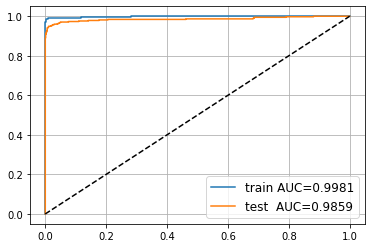

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('test ', X_test_bow, y_test, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.75, "Accuracy too low. There's likely a mistake in the code."
print("Well done!")

Okay, it definitely learned *something*. Now let's figure out what exactly it learned. The simplest way to do that is by highlighting which words have a greatest ratio of positive to negative probability or vice versa. We'll go with the negative one [because reasons](https://www.urbandictionary.com/define.php?term=because%20reasons).

__Your task__ is to compute top-25 words that have the __highest__ ratio of ${p(x_i | y=0)} \over {p(x_i | y=1)}$. Enjoy!

In [26]:
# hint: use naive_model.p_*
bow_vocabulary_2 = list(bow_vocabulary.keys())

probability_ratio = sorted(
    [(naive_model.p_x_given_positive[i] / naive_model.p_x_given_negative[i], i) 
    for i in range(len(naive_model.p_x_given_positive))], key=lambda tup: tup[0], 
    reverse=True)

top_negative_words = list(map(lambda p: bow_vocabulary_2[p[1]], probability_ratio))[:25]

for i, word in enumerate(top_negative_words):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={probability_ratio[bow_vocabulary_2.index(word)][0]})")

#0	     claim	(ratio=18.009311832841245)
#1	     prize	(ratio=18.009311832841245)
#2	        uk	(ratio=14.407449466272995)
#3	         å	(ratio=36.01862366568249)
#4	      150p	(ratio=14.407449466272995)
#5	      tone	(ratio=14.407449466272995)
#6	guaranteed	(ratio=10.805587099704747)
#7	       500	(ratio=10.805587099704747)
#8	        16	(ratio=10.805587099704747)
#9	       www	(ratio=18.009311832841245)
#10	       100	(ratio=10.805587099704747)
#11	        18	(ratio=10.805587099704747)
#12	   awarded	(ratio=10.805587099704747)
#13	    150ppm	(ratio=10.805587099704747)
#14	  ringtone	(ratio=10.805587099704747)
#15	     apply	(ratio=10.805587099704747)
#16	        50	(ratio=14.407449466272995)
#17	   service	(ratio=14.407449466272995)
#18	       000	(ratio=10.805587099704747)
#19	     pound	(ratio=10.805587099704747)
#20	      2000	(ratio=10.805587099704747)
#21	collection	(ratio=10.805587099704747)
#22	      http	(ratio=10.205276705276706)
#23	       10p	(ratio=10.805587099704747)
#24

Now lets try something less prehistoric: __Logistic Regression__. Turns out, if you're using silicon instead of an abacus, you can find model weights by optimizing the log-probability of the answer. Though, of course, you don't even need to write it by hand anymore. Let's sklearn it!

In [16]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

Model accuracy: 0.985
Well done!


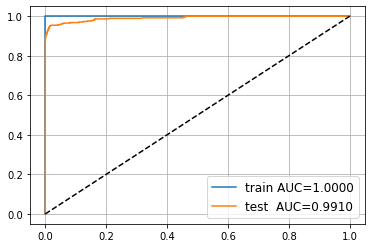

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(bow_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

### Task: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }} $$


, where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :) You can still use 'em for debugging though.

Model accuracy: 0.967
Well done!


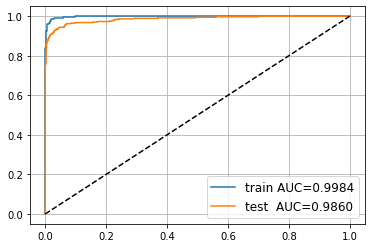

In [18]:
def tf(tokens):

    voc = dict()

    for token in tokens:
        if token not in voc.keys():
            voc[token] = 1
        else:
            voc[token] += 1

    for key in voc.keys():
        voc[key] = voc[key] / len(tokens)

    return voc


def idf(token, corpus):
    return np.log(len(corpus) / (sum([1 for t in corpus if token in t]) + 1))


def make_tf_idf_for_tokens(corpus):

    corpus = list(map(lambda cmnt: cmnt.split(' '), corpus))

    tf_idf_voc = dict()

    for comment in corpus:

        computed_tf = tf(comment)

        for word in computed_tf:

            tf_idf_voc[word] = computed_tf[word] * idf(word, corpus)

    return dict(sorted(tf_idf_voc.items(), key=lambda item: item[1], reverse=True)[:10000])


tf_idf_dict = make_tf_idf_for_tokens(corpus=texts_train)


def text_to_tf_idf(text):

    tf_idf = [0.0] * len(tf_idf_dict)
    tf_idf_map = dict()

    for num, word in enumerate(tf_idf_dict, start=0):
        tf_idf_map[word] = num

    for token in text.split(' '):
        if token in tf_idf_map:
            tf_idf[tf_idf_map[token]] = tf_idf_dict[token]

    return np.array(tf_idf, 'float32')


X_train_bow_2 = np.stack(list(map(text_to_tf_idf, texts_train)))
X_test_bow_2 = np.stack(list(map(text_to_tf_idf, texts_test)))

tf_model = LogisticRegression().fit(X_train_bow_2, y_train)

for name, X, y, model in [
    ('train', X_train_bow_2, y_train, tf_model),
    ('test ', X_test_bow_2, y_test, tf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(tf_model.predict(X_test_bow_2) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")



### Solving it better: word vectors

Let's try another approach: instead of counting per-word frequencies, we shall map all words to pre-trained word vectors and average over them to get text features.

This should give us two key advantages: (1) we now have 10^2 features instead of 10^4 and (2) our model can generalize to word that are not in training dataset.

We begin with a standard approach with pre-trained word vectors. However, you may also try
* training embeddings from scratch on relevant (unlabeled) data
* multiplying word vectors by inverse word frequency in dataset (like tf-idf).
* concatenating several embeddings
    * call `gensim.downloader.info()['models'].keys()` to get a list of available models
* clusterizing words by their word-vectors and try bag of cluster_ids

__Note:__ loading pre-trained model may take a while. It's a perfect opportunity to refill your cup of tea/coffee and grab some extra cookies. Or binge-watch some tv series if you're slow on internet connection

In [19]:
import gensim.downloader 
embeddings = gensim.downloader.load("glove-wiki-gigaword-100")

# If you're low on RAM or download speed, use "glove-wiki-gigaword-100" instead

[==================================================] 100.0% 128.1/128.1MB downloaded


In [20]:
def vectorize_sum(comment):
    """
    implement a function that converts preprocessed comment to a sum of token vectors
    """
    embedding_dim = embeddings.wv.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')
    for token in comment.split(' '):
      try:
        features += embeddings.get_vector(token)
      except KeyError:
        pass
    return features

In [21]:
X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


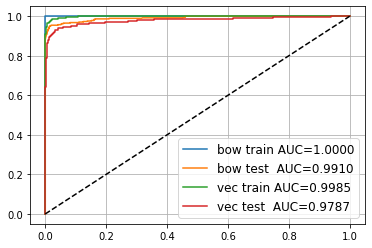

In [25]:
wv_model = LogisticRegression(max_iter=1000).fit(X_train_wv, y_train)

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

assert roc_auc_score(y_test, wv_model.predict_proba(X_test_wv)[:, 1]) > 0.92, "something's wrong with your features"

If everything went right, you've just managed to reduce misclassification rate by a factor of two.
This trick is very useful when you're dealing with small datasets. However, if you have hundreds of thousands of samples, there's a whole different range of methods for that.